# Лабораторна робота №2. Методи класифікації
## Виконав студент групи КМ-91мп
## Галета М.С.
## Завдання на лабораторну роботу
<img src="task1.png">

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

## Зчитування датасету та його розбиття на тренувальну та відкладену вибірки

In [2]:
df = pd.read_csv('MP-04-Galeta.csv', sep=';', names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'y'])

X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

## Побудова дерева рішень

In [3]:
class Tree:
    def __init__(self, parent=None):
        self.parent = parent
        self.children = []
        self.splitFeature = None
        self.splitFeatureValue = None
        self.label = None

In [4]:
def dataToDistribution(data):
    ''' Функція перетворює набір даних, який має n можливих
        класифікаційних міток, в розподіл ймовірностей з n записами. '''
    
    allLabels = [label for (point, label) in data]
    numEntries = len(allLabels)
    possibleLabels = set(allLabels)
    dist= []
    for aLabel in possibleLabels:
        dist.append(float(allLabels.count(aLabel)) / numEntries)
    return dist

In [5]:
def entropy(dist):
    ''' Функція обчислює ентропію Шеннона для заданого розподілу ймовірностей. '''
    return -sum([p * math.log(p, 2) for p in dist])

In [6]:
def splitData(data, featureIndex):
    ''' Функція виконує ітерацію над підмножинами даних,
        що відповідають кожному значенню функції в індексі featureIndex.'''
    
    # отримання можливих значень заданої ознаки
    attrValues= [point[featureIndex] for (point, label) in data]
    for aValue in set(attrValues):
        # обчислення частини розбиття, що відповідає обраному значенню
        dataSubset= [(point, label) for (point, label) in data if point[featureIndex] == aValue]
        yield dataSubset

In [7]:
def gain(data, featureIndex):
    ''' Функція обчислює очікуваний приріст інформації від
        розбиття даних на всі можливі значення функції '''
    
    entropyGain = entropy(dataToDistribution(data))
    for dataSubset in splitData(data, featureIndex):
        entropyGain -= entropy(dataToDistribution(dataSubset))
    return entropyGain

In [8]:
def homogeneous(data):
    ''' Функція повертає True, якщо дані мають однакову мітку,
        і False в іншому випадку '''
    return len(set([label for (point, label) in data])) <= 1

In [9]:
def majorityVote(data, node):
    ''' Функція повертає вузол мітки з більшістю міток класу в даному наборі даних '''
    
    labels = [label for (point, label) in data]
    choice = max(set(labels), key=labels.count)
    node.label= choice
    return node

In [10]:
def buildDecisionTree(data, root, remainingFeatures, max_depth):
    ''' Функція будує дерево рішень з даних даних,
        додаючи дітей до кореневого вузла (який може бути піддеревом) '''
    
    # Глобальна змінна, яка позначає поточну глибину дерева
    global current_depth
    
    # Зупиняємось, якщо поточна глибина більша за максимально допустиму глибину дерева
    if current_depth >= max_depth:
        remainingFeatures = []
    
    # Якщо всі елементи мають однаковий клас, то класифікуємо листок дерева міткою цього класу
    if homogeneous(data):
        root.label= data[0][1]
        root.classCounts = {root.label: len(data)}
        return root
    
    # Якщо немає більше ознак для подальшого розбиття, 
    # то класифікуємо листок дерева міткою класу якого більшість
    if len(remainingFeatures) == 0:
        return majorityVote(data, root)
    
    # Знаходження індексу найкращої функції для поділу
    bestFeature= max(remainingFeatures, key=lambda index: gain(data, index))
    # Якщо приріст інформації дорівнює нулю,
    # то класифікуємо листок дерева міткою класу якого більшість
    if gain(data, bestFeature) == 0:
        return majorityVote(data, root)
    
    root.splitFeature = bestFeature
    
    #Додавання дочірніх вузлів для вже існуючих
    for dataSubset in splitData(data, bestFeature):
        aChild = Tree(parent=root)
        aChild.splitFeatureValue = dataSubset[0][0][bestFeature]
        root.children.append(aChild)
        
        #Запуск рекурсивного процесу, де дочірні вузли виступають в якості батьківського вузла
        buildDecisionTree(dataSubset, aChild, remainingFeatures - set([bestFeature]), max_depth)
        
    current_depth += 1
    
    return root

In [11]:
def decisionTree(data, max_depth):
    ''' Функція повертає збудоване дерево '''
    return buildDecisionTree(data, Tree(), set(range(len(data[0][0]))), max_depth)

In [12]:
def classify(tree, point):
    ''' Функція класифікаці даних шляхом проходження даного дерева рішень. '''
    if tree.children== []:
        return tree.label
    else:
        matchingChildren = []
        for child in tree.children:
            if child.splitFeatureValue == point[tree.splitFeature]:
                matchingChildren.append(child)
                
        try:
            return classify(matchingChildren[0], point)
        except Exception:
            return child.label

## Оцінювання якості збудованого дерева

In [13]:
train_data = [(x[:-1], x[-1]) for x in X_train.values.tolist()]
test_data = [(x[:-1], x[-1]) for x in X_test.values.tolist()]

y_train = np.array([label for point, label in train_data])
y_test = np.array([label for point, label in test_data])

for max_depth in range(2, 11):
    current_depth = 0
    tree = decisionTree(train_data, max_depth=max_depth)

    y_predicted_train = [classify(tree, point) for point, label in train_data]
    y_predicted_test = [classify(tree, point) for point, label in test_data]
    
    accuracy_test = (y_predicted_test == y_test).mean()
    accuracy_train = (y_predicted_train == y_train).mean()
    
    print('============= max_depth -', max_depth, '=============')
    print('Train accuracy:',np.round(accuracy_train*100,2),'%')
    print('Test accuracy:',accuracy_test*100,'%')
    print('')

============= max_depth - 2 =============
Train accuracy: 44.23 %
Test accuracy: 23.076923076923077 %

============= max_depth - 3 =============
Train accuracy: 44.23 %
Test accuracy: 23.076923076923077 %

============= max_depth - 4 =============
Train accuracy: 44.23 %
Test accuracy: 23.076923076923077 %

============= max_depth - 5 =============
Train accuracy: 44.23 %
Test accuracy: 23.076923076923077 %

============= max_depth - 6 =============
Train accuracy: 46.15 %
Test accuracy: 15.384615384615385 %

============= max_depth - 7 =============
Train accuracy: 46.15 %
Test accuracy: 15.384615384615385 %

============= max_depth - 8 =============
Train accuracy: 57.69 %
Test accuracy: 0.0 %

============= max_depth - 9 =============
Train accuracy: 63.46 %
Test accuracy: 0.0 %

============= max_depth - 10 =============
Train accuracy: 63.46 %
Test accuracy: 0.0 %



### Отже, при глибині дерева 2, 3, 4 або 5 воно найкраще класифікує відкладену вибірку

In [14]:
train_data = [(x[:-1], x[-1]) for x in X_train.values.tolist()]
test_data = [(x[:-1], x[-1]) for x in X_test.values.tolist()]

y_train = np.array([label for point, label in train_data])
y_test = np.array([label for point, label in test_data])

current_depth = 0
tree = decisionTree(train_data, max_depth=4)

y_predicted_train = [classify(tree, point) for point, label in train_data]
y_predicted_test = [classify(tree, point) for point, label in test_data]

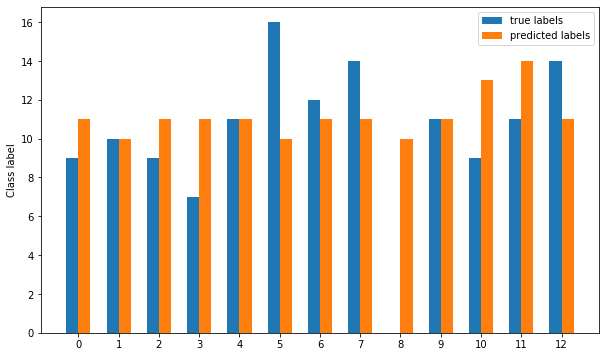

In [15]:
x = np.arange(len(y_test)) 
width = 0.3

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, y_test, width, label='true labels')
ax.bar(x + width/2, y_predicted_test, width, label='predicted labels')

ax.set_ylabel('Class label')
ax.set_xticks(x)
ax.legend()
plt.show()

## Метод KNN

In [16]:
x_train = X_train[X_train.columns[0:-1]].values
y_train = X_train[X_train.columns[-1]].values
x_test = X_test[X_test.columns[0:-1]].values
y_test = X_test[X_test.columns[-1]].values

In [17]:
def compute_distances(x_known, x_unknown):
    
    num_pred = x_unknown.shape[0]
    num_data = x_known.shape[0]
    
    dists = np.zeros((num_pred, num_data))

    for i in range(num_pred):
        for j in range(num_data):
            dists[i,j] = np.sum(x_known[j] == x_unknown[i])
            
    return dists

In [18]:
def k_nearest_labels(dists, y_known, k):
        
    num_pred = dists.shape[0]
    n_nearest = []
    
    for j in range(num_pred):
        dst = dists[j]
        closest_y = y_known[np.argpartition(dst, k-1)[:k]]
        
        n_nearest.append(closest_y)
        
    return np.asarray(n_nearest)

In [19]:
class KNearest_Neighbours:
    
    def __init__(self, k):
        self.k = k
        self.test_set_x = None
        self.train_set_x = None
        self.train_set_y = None

        
    def fit(self, train_set_x, train_set_y):
        self.train_set_x = train_set_x
        self.train_set_y = train_set_y
        
    def predict(self, test_set_x):

        y_labels = k_nearest_labels(compute_distances(self.train_set_x, test_set_x), self.train_set_y, self.k)
        y_predictions = []
        for i in range(y_labels.shape[0]):
            bc = np.bincount(y_labels[i])
            y_predictions.append(np.arange(len(bc))[bc == bc.max()].min())
        
        return y_predictions

In [20]:
for k in range(1, 10, 2):
    knn = KNearest_Neighbours(k)
    knn.fit(x_train, y_train)
    y_pred_knn = knn.predict(x_test)
    accuracy = (y_pred_knn == y_test).mean() * 100
    print("k = {}; accuracy = {}%".format(k, accuracy))

k = 1; accuracy = 7.6923076923076925%
k = 3; accuracy = 15.384615384615385%
k = 5; accuracy = 15.384615384615385%
k = 7; accuracy = 15.384615384615385%
k = 9; accuracy = 7.6923076923076925%


### З даних результатів видно, що для даного набору даних кількість сусідів, при якій алгоритм дає найбільшу точність, дорівнює 3, 5 або 7. Гірша точність при К = 1 або 9.

In [21]:
knn = KNearest_Neighbours(5)
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)

In [22]:
print("К найближчих сусідів:    ",y_pred_knn)
print("Дерева прийняття рішень: ",y_predicted_test)

К найближчих сусідів:     [10, 10, 10, 10, 13, 10, 13, 8, 10, 13, 9, 9, 10]
Дерева прийняття рішень:  [11, 10, 11, 11, 11, 10, 11, 11, 10, 11, 13, 14, 11]


In [23]:
print("Кількість однаково спрогнозованих значень двома методами: ",sum(np.array(y_predicted_test) == (y_pred_knn)))

Кількість однаково спрогнозованих значень двома методами:  3


## Висновки
##### 1) Було реалізовано два методи класифікації: дерево прийняття рішень та KNN
##### 2) В ході роботи було встановлено, що дерево прийняття рішень дає кращий результат на відкладеній вибірці, ніж KNN